# RU 29 processing

some quick ideas for steps to process RU29 data into useful bits for science

In [1]:
import xarray as xr
from erddapy import ERDDAP
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

import numpy as np

from scipy.signal import find_peaks


# grab the science data from ERDDAP

In [2]:

# this creates a link to the RUCOOL server:
e = ERDDAP(
    server="http://slocum-data.marine.rutgers.edu/erddap",
    protocol="tabledap",
    response="nc",
)

# get the science data:
e.dataset_id = 'ru29-20200908T1623-profile-sci-rt'

# this connects to the data and load into an xarray
ds = e.to_xarray()
# ds = e.to_pandas()


# swap the dims so you can work with time:
# this maaaaay not work
ds = ds.swap_dims({"obs": "time"})

ds

<xarray.Dataset>
Dimensions:                        (profile: 445, time: 413199)
Coordinates:
  * time                           (time) datetime64[ns] 2020-09-08T16:28:35....
    latitude                       (time) float64 ...
    longitude                      (time) float64 ...
    depth                          (time) float32 ...
Dimensions without coordinates: profile
Data variables:
    profile_id                     (profile) float64 ...
    rowSize                        (profile) int32 ...
    trajectory                     (time) object ...
    source_file                    (time) object ...
    beta_700nm                     (time) float32 ...
    cdom                           (time) float32 ...
    chlorophyll_a                  (time) float32 ...
    conductivity                   (time) float32 ...
    crs                            (time) float64 ...
    ctd41cp_timestamp              (time) datetime64[ns] ...
    density                        (time) float32 ...
    flbbcd_timestamp               (time) datetime64[ns] ...
    instrument_adcp                (time) float64 ...
    instrument_ctd                 (time) float64 ...
    instrument_flbbcd              (time) float64 ...
    m_pitch                        (time) float32 ...
    m_roll                         (time) float32 ...
    m_science_clothesline_lag      (time) float32 ...
    platform                       (time) float64 ...
    potential_temperature          (time) float32 ...
    pressure                       (time) float32 ...
    profile_lat                    (time) float64 ...
    profile_lon                    (time) float64 ...
    profile_time                   (time) datetime64[ns] ...
    salinity                       (time) float32 ...
    sci_ad2cp_bottom_track_signal  (time) float32 ...
    sci_ad2cp_file_state           (time) float32 ...
    sci_ad2cp_run_state            (time) float32 ...
    sci_ad2cp_surface_state        (time) float32 ...
    sci_m_disk_free                (time) float32 ...
    sci_m_present_time             (time) datetime64[ns] ...
    sci_water_pressure             (time) float32 ...
    sound_speed                    (time) float32 ...
    temperature                    (time) float32 ...
    u                              (time) float32 ...
    v                              (time) float32 ...
    water_depth                    (time) float32 ...
Attributes:
    cdm_data_type:                   Profile
    cdm_profile_variables:           profile_id
    comment:                         Deployed by Antonio Farchetti, Kenique L...
    contributor_name:                Scott Glenn,Oscar Schofield,Travis Miles...
    contributor_role:                Principal Investigator,Principal Investi...
    Conventions:                     CF-1.6, COARDS, ACDD-1.3
    creator_email:                   kerfoot@marine.rutgers.edu
    creator_institution:             Rutgers University
    creator_name:                    John Kerfoot
    creator_type:                    person
    creator_url:                     https://rucool.marine.rutgers.edu
    date_created:                    2020-09-09T14:01:19Z
    date_issued:                     2020-09-09T14:01:19Z
    date_modified:                   2020-09-09T14:01:19Z
    defaultGraphQuery:               temperature,depth,time&time>=max(time)-1...
    deployment_name:                 ru29-20200908T1623
    Easternmost_Easting:             -63.938824042143295
    featureType:                     Profile
    geospatial_bounds:               POLYGON ((18.1771509614141 -64.805848403...
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:5831
    geospatial_lat_max:              18.17940211153476
    geospatial_lat_min:              17.42431
    geospatial_lat_resolution:       0.00001 degree
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              -63.938824042143295
    geospatial_lon_min:            

# Create dataset for profile-avg data

Get unique profile data (eg lat, lon)


In [3]:
# get just the unique profile midpoint times
# also return the index of those values for later use
prof_time, indicies = np.unique(ds.profile_time.values, return_index = True)

print(indicies.shape)

# grab the U and V depth-avergage, forward fill all the nans, then just grab the profile midpoint
profiles = xr.merge( [ds.u.ffill('time')[indicies], ds.v.ffill('time')[indicies] ])


profiles

(631,)


<xarray.Dataset>
Dimensions:    (time: 631)
Coordinates:
  * time       (time) datetime64[ns] 2020-09-08T16:28:35.565609984 ... 2020-1...
    latitude   (time) float64 18.18 18.18 18.18 18.18 ... 18.03 18.04 18.06
    longitude  (time) float64 -64.81 -64.8 -64.81 -64.8 ... -64.79 -64.79 -64.79
    depth      (time) float32 6.2919054 123.407326 ... 0.18886074 967.64325
Data variables:
    u          (time) float32 nan -0.156687 -0.156687 ... -0.0977082 -0.108397
    v          (time) float32 nan 0.0218536 0.0218536 ... 0.00462933 -0.0127249

# plot currents

In [4]:
# get a subset of the etopo bathymetry data

lat_lims = [16, 18.9]
lon_lims = [-66, -61]

# grab some bathymetry

url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'

etopo1 = xr.open_dataset(url).sel(lat = slice(lat_lims[0], lat_lims[1]), lon = slice(lon_lims[0], lon_lims[1] ))


/Users/beaird/anaconda3/envs/fm2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in cos
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/Users/beaird/anaconda3/envs/fm2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in sin
  u, v = self.projection.transform_vectors(t, x, y, u, v)


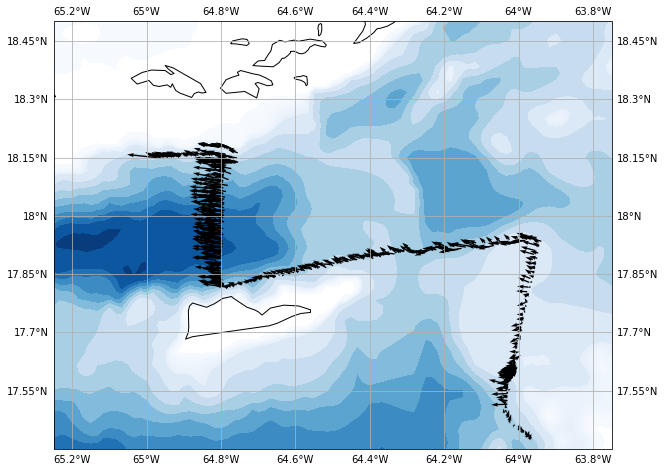

In [5]:
plt.figure(figsize = (10,10))
ax = plt.axes( projection = ccrs.Mercator())

ax.coastlines(resolution='10m')

dpth_contours = np.append(np.arange(-5000, -500, 500), np.arange(-500, 0, 50)) 

plt.contourf( etopo1.lon, etopo1.lat, etopo1.topo, dpth_contours , transform=ccrs.PlateCarree(), cmap='Blues_r')

plt.quiver(profiles.longitude.values, profiles.latitude.values, 
           profiles.u.values, profiles.v.values, transform=ccrs.PlateCarree() )

ax.set_extent((-65.25,-63.75, 17.4, 18.5) )

ax.gridlines(draw_labels=True)

# Isolate the individual Anegada sections

we should be able to automatically pick out the sections across the Anegada passage. The code below is some grade-A ad-hocary, which only works because the sections are so nicely north south (note where it doesn't work it's beacuase `find_peaks()` can't ID the points near a plateau).

There has to be a better way to do this! It looks like this group: https://github.com/oceanhackweek/ohw20-proj-shiptrack worked on the problem. It'd be fun to get that code running. Could be useful for a lot of glider data!

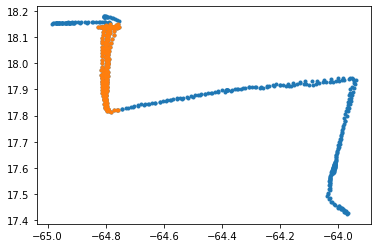

In [6]:
# look for some conditions to get the anegada passage points:
anegada_crossings = profiles.where((profiles.longitude < -64.75) & (profiles.latitude < 18.15),  drop=True)

anegada_crossings

plt.plot(profiles.longitude, profiles.latitude, '.')
plt.plot(anegada_crossings.longitude, anegada_crossings.latitude, '.')

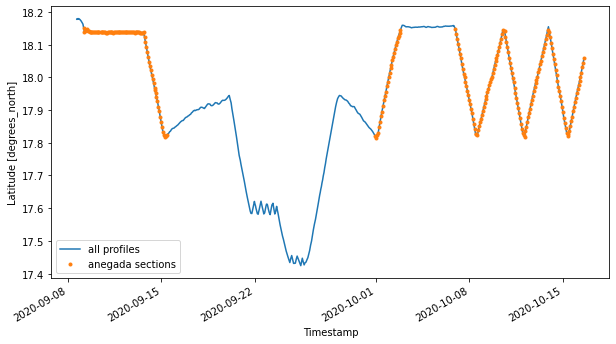

In [7]:

# plot lat vs time to see the crossings
plt.figure( figsize=(10,5))
profiles.latitude.plot( label='all profiles')
anegada_crossings.latitude.plot(marker = '.', linestyle='', label='anegada sections')

plt.legend()


In [8]:


prom = .05

Nends, propN = find_peaks(anegada_crossings.latitude,  threshold=None, distance=None, prominence=prom)
Sends, prop = find_peaks( -1*anegada_crossings.latitude,  threshold=None, distance=None, prominence=prom)


sections = np.sort(np.append(Nends, Sends ))


Some start and end times:
glider at North end: ['2020-10-06T23:13:26.640749824' '2020-10-10T12:16:35.661040128'
 '2020-10-13T20:24:42.395840000']
glider at South end: ['2020-10-06T23:13:26.640749824' '2020-10-10T12:16:35.661040128'
 '2020-10-13T20:24:42.395840000']


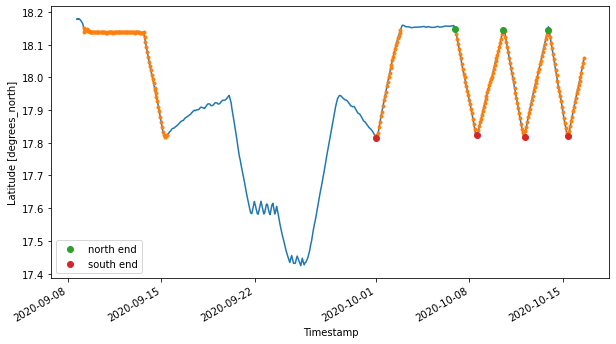

In [9]:
plt.figure( figsize=(10,5))
profiles.latitude.plot()
anegada_crossings.latitude.plot(marker = '.', linestyle='')

plt.plot(anegada_crossings.time[Nends] , anegada_crossings.latitude[Nends], 'o', label='north end' )
plt.plot(anegada_crossings.time[Sends] , anegada_crossings.latitude[Sends], 'o' , label='south end')
plt.legend()

print('Some start and end times:')
print('glider at North end:', anegada_crossings.time[Nends].values )
print('glider at South end:', anegada_crossings.time[Nends].values )